In [4]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import os
import seaborn as sns
import sys
sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from functions import *

colors = ['#b3e2cd', '#fdcdac']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate data

In [49]:
start = time.time()

all_data = []

model_dir = sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/'))
# betas_allmodels = []
# betas_allmodels_nosst = []
# beta_conjs_allmodels = []
# beta_conjs_allmodels_nosst = []
# rsqrs_allmodels = []
# rsqrs_nosst_allmodels = []
# rsqr_conjs_allmodels = []
# rsqr_conjs_nosst_allmodels = []

skip_trials = 10    # skip the first 10 trials since there may be transient activity caused by a large initial condition

for model_name in model_dir:
    if '2023-05-10' in model_name and 'success' in model_name:
        print(model_name+'\n')
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, 
                                                                            simple=False, plot=False, toprint=False)
        
        # filter
        if hp_test['dt']!=10:
            continue
#         if hp_test['dend_nonlinearity'] not in ['divisive_2']:
#             continue
        if hp_test['sparse_srsst_to_sredend']!=0:
            continue
        for key in ['dend_nonlinearity', 'sparse_srsst_to_sredend', 'initialization_weights', 'activation']:
            print(key, hp_test[key])
        
        # load test data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data'] 
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
#         neuron_idx = model.rnn.cg_idx['sr_esoma'].tolist() + model.rnn.cg_idx['sr_pv'].tolist() + model.rnn.cg_idx['sr_sst'].tolist() + model.rnn.cg_idx['sr_vip'].tolist()
        neuron_idx = model.rnn.cg_idx['sr_esoma'].tolist()
        rnn_activity = rnn_activity[:, :, :, neuron_idx]
#         print(rnn_activity.shape)


        # silence SST
        # load test data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_silenceSRSST_noiseless_no_current_matrix'), 'rb') as f:
            neural_data_nosst = pickle.load(f)
        test_data_nosst = neural_data_nosst['test_data']
        if (np.sum(np.array([_[0].numpy() for _ in test_data_nosst['resps']]), axis=1)==0).any():
            print('During some trials, the network does not make a response, pass')
            continue
        mean_perf_nosst = np.mean([_[0] for _ in test_data_nosst['perfs']])
        mean_perf_rule_nosst = np.mean([_[0] for _ in test_data_nosst['perf_rules']])
#         if mean_perf_nosst<0.8 or mean_perf_rule_nosst<0.8:
#             print('low performing model ({}/{})'.format(mean_perf_nosst, mean_perf_rule_nosst))
#             continue
        rnn_activity_nosst = neural_data_nosst['rnn_activity'].detach().cpu().numpy()
        rnn_activity_nosst = rnn_activity_nosst[:, :, :, neuron_idx]
        
        
        
        #===== analysis =====#
        rules = test_data['rules']    # a list of rules from the test data
        resps = [torch.where(_[0]==1)[0].numpy()[0] for _ in test_data['resps']]    # a list of responses
        stims = [((_[0]['center_card']['color'], _[0]['center_card']['shape']),
                  (_[0]['test_cards'][0]['color'], _[0]['test_cards'][0]['shape']),
                  (_[0]['test_cards'][1]['color'], _[0]['test_cards'][1]['shape']),
                  (_[0]['test_cards'][2]['color'], _[0]['test_cards'][2]['shape'])) for _ in test_data['stims']]    # a list of stims
        betas, beta_conjs, rsqrs, rsqr_conjs, residual_activities, predicted_activities = beta_conj(rnn_activity=rnn_activity[skip_trials:, :, :, :], stims=stims[skip_trials:], rules=rules[skip_trials:], resps=resps[skip_trials:], hp_task_test=hp_task_test, hp_test=hp_test)
        # betas_allmodels.extend(betas)
        # beta_conjs_allmodels.extend(beta_conjs)
        # rsqrs_allmodels.extend(rsqrs)
        # rsqr_conjs_allmodels.extend(rsqr_conjs)
        
        # silence SST
        rules_nosst = test_data_nosst['rules']    # a list of rules from the test data
        resps_nosst = [torch.where(_[0]==1)[0].numpy()[0] for _ in test_data_nosst['resps']]    # a list of responses
        stims_nosst = [((_[0]['center_card']['color'], _[0]['center_card']['shape']),
                      (_[0]['test_cards'][0]['color'], _[0]['test_cards'][0]['shape']),
                      (_[0]['test_cards'][1]['color'], _[0]['test_cards'][1]['shape']),
                      (_[0]['test_cards'][2]['color'], _[0]['test_cards'][2]['shape'])) for _ in test_data_nosst['stims']]    # a list of stims
        betas_nosst, beta_conjs_nosst, rsqrs_nosst, rsqr_conjs_nosst, residual_activities_nosst, predicted_activities_nosst = beta_conj(rnn_activity=rnn_activity_nosst[skip_trials:, :, :, :], stims=stims_nosst[skip_trials:], rules=rules_nosst[skip_trials:], resps=resps_nosst[skip_trials:], hp_task_test=hp_task_test, hp_test=hp_test)
        # betas_allmodels_nosst.extend(betas_nosst)
        # beta_conjs_allmodels_nosst.extend(beta_conjs_nosst)
        # rsqrs_nosst_allmodels.extend(rsqrs_nosst)
        # rsqr_conjs_nosst_allmodels.extend(rsqr_conjs_nosst)

       
        
        all_data.append({'model_name': model_name,
                         'hp': hp_test,
                         'betas': betas,
                         'beta_conjs': beta_conjs,
                         'rsqrs': rsqrs,
                         'rsqr_conjs': rsqr_conjs,
                         'betas_nosst': betas_nosst,
                         'beta_conjs_nosst': beta_conjs_nosst,
                         'rsqrs_nosst': rsqrs_nosst,
                         'rsqr_conjs_nosst': rsqr_conjs_nosst,
                         'predicted_activities': predicted_activities,
                         'residual_activities': residual_activities,
                         'predicted_activities_nosst': predicted_activities_nosst,
                         'residual_activities_nosst': residual_activities_nosst})
        
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conj_coding.pickle', 'wb') as f:
    pickle.dump(all_data, f)
print('Elapsed time: {}s'.format(time.time()-start))

success_2023-05-10-14-28-42_wcst_105_sparsity0

dend_nonlinearity divisive_2
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu
success_2023-05-10-14-28-42_wcst_106_sparsity0

dend_nonlinearity divisive_2
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu
During some trials, the network does not make a response, pass
success_2023-05-10-14-28-42_wcst_10_sparsity0

dend_nonlinearity subtractive
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu
success_2023-05-10-14-28-42_wcst_112_sparsity0

dend_nonlinearity divisive_2
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu
low performing model (0.0/0.0)
success_2023-05-10-14-28-42_wcst_115_sparsity0

dend_nonlinearity divisive_2
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu
low performing model (0.125/0.02500000037252903)
success_2023-05-10-14-28-42_wcst_116_sparsity0

dend_nonlinearity divisi

# Figure 7g + Supplementary Figure 11d: R^2 for conjunctive regression model, across network models

subtractive


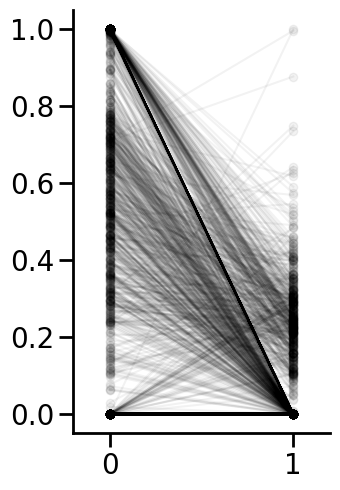

Ttest_indResult(statistic=29.905278570791307, pvalue=1.7465532070259296e-175)
n=1750
divisive_2


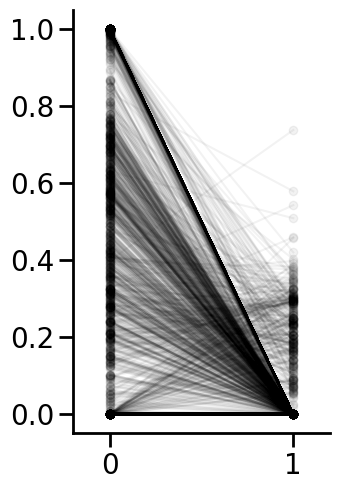

Ttest_indResult(statistic=45.069571194565476, pvalue=0.0)
n=1680


In [50]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conj_coding.pickle', 'rb') as handle:
    all_data = pickle.load(handle)
    

data_nonlinearMix = {'subtractive': {}, 'divisive_2': {}}

for dend_nonlinearity in ['subtractive', 'divisive_2']:
    print(dend_nonlinearity)
    rsqr_conjs = []
    rsqr_conjs_nosst = []
    for data in all_data:
        if data['hp']['dend_nonlinearity']==dend_nonlinearity: 
            rsqr_conjs.extend(data['rsqr_conjs'])
            rsqr_conjs_nosst.extend(data['rsqr_conjs_nosst'])
    y = [rsqr_conjs, rsqr_conjs_nosst]
    colors = ['#b3e2cd', '#fdcdac']
    fig, ax = plt.subplots(figsize=[3.5, 5])
    ax.plot([0, 1], y, color='k', alpha=0.05, marker='o')
    make_pretty_axes(ax)
    ax.set_xlim([-0.2, 1.2])
    ax.set_xticks([0, 1])
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conj_rsquare_{}.pdf'.format(dend_nonlinearity))

    # statistical test
    print(stats.ttest_ind(a=rsqr_conjs, b=rsqr_conjs_nosst, alternative='greater'))
    print('n={}'.format(len(rsqr_conjs)))

    # save source data    
    data_nonlinearMix[dend_nonlinearity] = {'intact': rsqr_conjs, 'silence_sst': rsqr_conjs_nosst}
    pd.DataFrame.from_dict(data=data_nonlinearMix[dend_nonlinearity], orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/nonlinear_mix_rsquares{}.csv'.format(dend_nonlinearity), header=False)
    

# Supplementary Figure 12: the prediction of the regression model before and after silencing SST units, for some example units 

success_2023-05-10-14-28-42_wcst_105_sparsity0
success_2023-05-10-14-28-42_wcst_10_sparsity0
success_2023-05-10-14-28-42_wcst_116_sparsity0


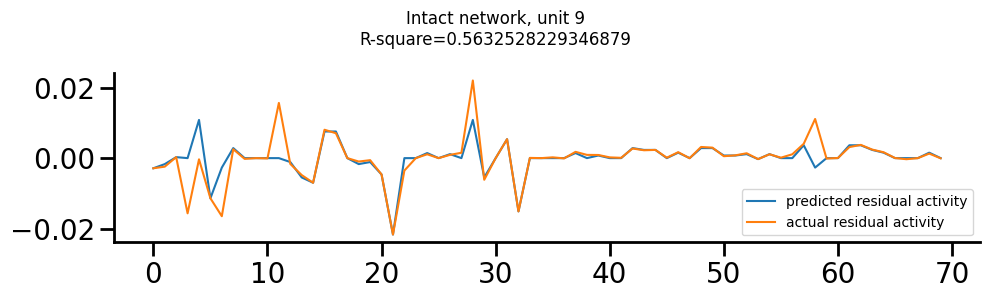

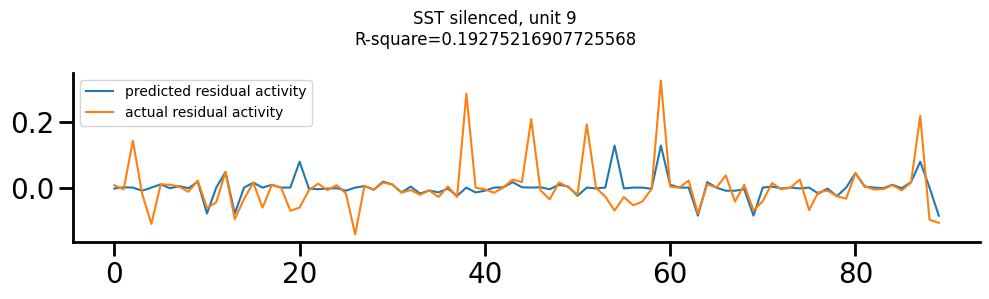

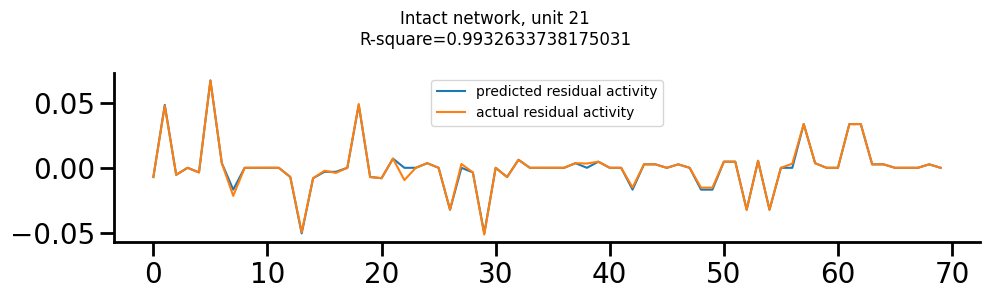

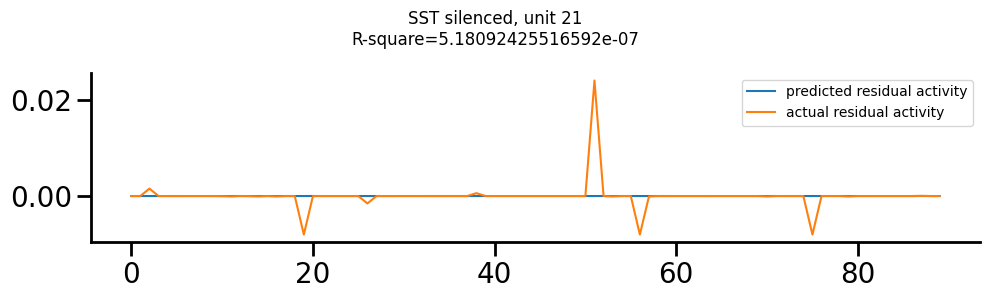

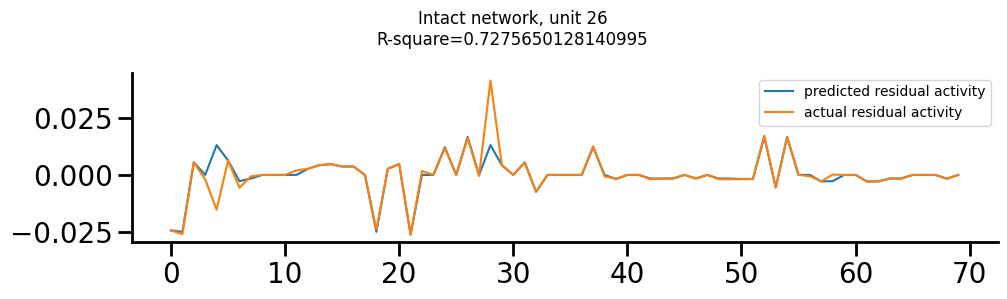

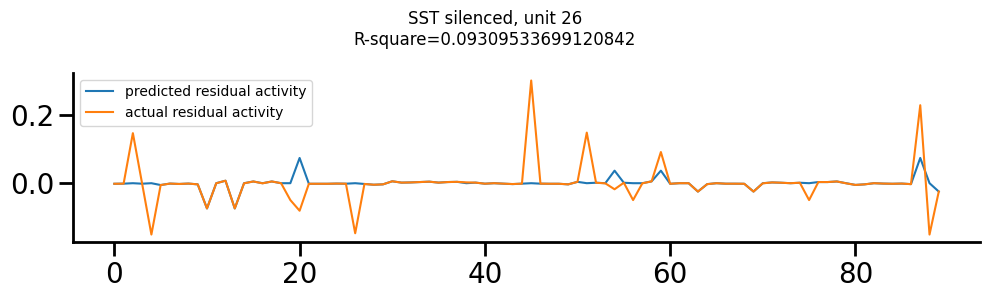

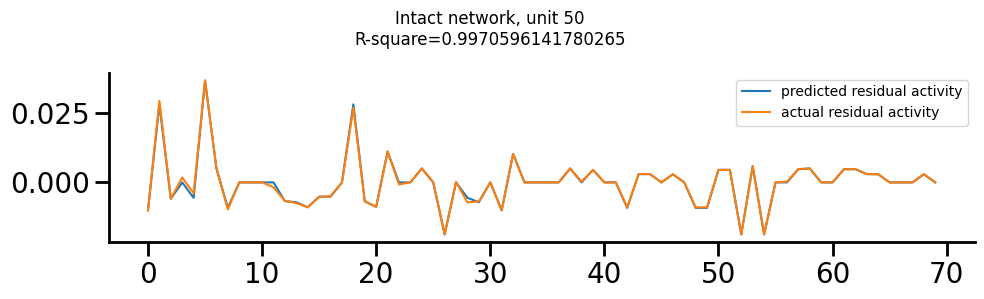

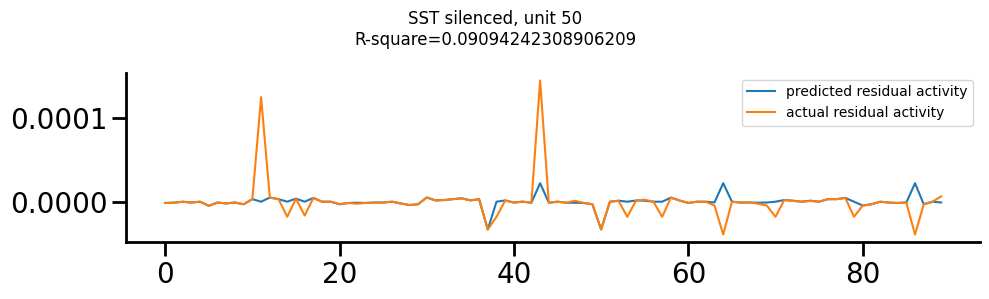

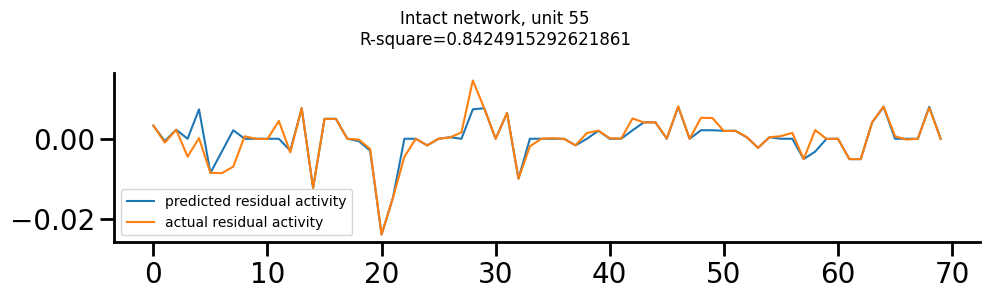

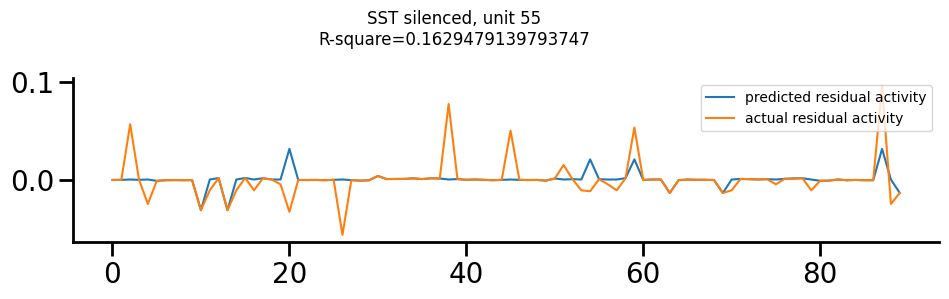

success_2023-05-10-14-28-42_wcst_118_sparsity0
success_2023-05-10-14-28-42_wcst_121_sparsity0
success_2023-05-10-14-28-42_wcst_124_sparsity0
success_2023-05-10-14-28-42_wcst_126_sparsity0
success_2023-05-10-14-28-42_wcst_131_sparsity0
success_2023-05-10-14-28-42_wcst_134_sparsity0
success_2023-05-10-14-28-42_wcst_136_sparsity0
success_2023-05-10-14-28-42_wcst_139_sparsity0
success_2023-05-10-14-28-42_wcst_142_sparsity0
success_2023-05-10-14-28-42_wcst_144_sparsity0
success_2023-05-10-14-28-42_wcst_149_sparsity0
success_2023-05-10-14-28-42_wcst_151_sparsity0
success_2023-05-10-14-28-42_wcst_156_sparsity0
success_2023-05-10-14-28-42_wcst_165_sparsity0
success_2023-05-10-14-28-42_wcst_16_sparsity0
success_2023-05-10-14-28-42_wcst_170_sparsity0
success_2023-05-10-14-28-42_wcst_176_sparsity0
success_2023-05-10-14-28-42_wcst_177_sparsity0
success_2023-05-10-14-28-42_wcst_179_sparsity0
success_2023-05-10-14-28-42_wcst_17_sparsity0
success_2023-05-10-14-28-42_wcst_180_sparsity0
success_2023-05

In [58]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conj_coding.pickle', 'wb') as f:
    pickle.dump(all_data, f)

data_suppfig12 = {'intact': {}, 'silenceSST': {}}

neuron_ids = [9, 21, 26, 50, 55]    # pick some example unts

for data in all_data:
    print(data['model_name'])
    if data['model_name'] != 'success_2023-05-10-14-28-42_wcst_116_sparsity0':
        continue    # pick an example network
    r_sqr_conjs = data['rsqr_conjs']    # r-square values for the regression model with conjunctive term
    rsqr_conjs_nosst = data['rsqr_conjs_nosst']    # same but for when SST neurons are silenced
    
    predicted_activities = data['predicted_activities']    # predicted residual activity by the regression model with the conjunctive terms across all neurons. Get rid of the transient activity for the first few trials
    residual_activities = data['residual_activities']   # actual residual activity across all neurons
    predicted_activities_nosst = data['predicted_activities_nosst']    # same but when SST are silenced
    residual_activities_nosst = data['residual_activities_nosst']
    
    # plot the prediction versus actual residual activity
    n_neurons = predicted_activities.shape[0]
    for n in range(n_neurons):
        if n not in neuron_ids:
            continue    
        if r_sqr_conjs[n]== 0 or rsqr_conjs_nosst[n] == 0:
            print('r-square = 0 due to inactivity of this unit')
            continue
        fig, ax = plt.subplots(1, 1, figsize=[10, 3])
        fig.suptitle('Intact network, unit {}\nR-square={}'.format(n, r_sqr_conjs[n]))
        ax.plot(predicted_activities[n], label='predicted residual activity')
        ax.plot(residual_activities[n], label='actual residual activity')
        ax.legend()
        ax.legend()
        make_pretty_axes(ax)
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conj_coding_example_unit{}_intact.pdf'.format(n))
        data_suppfig12['intact'][n] = {}
        data_suppfig12['intact'][n]['predicted'] = predicted_activities[n]
        data_suppfig12['intact'][n]['actual'] = residual_activities[n]

        
        fig, ax = plt.subplots(1, 1, figsize=[10, 3])
        fig.suptitle('SST silenced, unit {}\nR-square={}'.format(n, rsqr_conjs_nosst[n]))
        ax.plot(predicted_activities_nosst[n], label='predicted residual activity')
        ax.plot(residual_activities_nosst[n], label='actual residual activity')
        ax.legend()
        ax.legend()
        make_pretty_axes(ax)
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conj_coding_example_unit{}_noSST.pdf'.format(n))
        data_suppfig12['silenceSST'][n] = {}
        data_suppfig12['silenceSST'][n]['predicted'] = predicted_activities[n]
        data_suppfig12['silenceSST'][n]['actual'] = residual_activities[n]

for condition in ['intact', 'silenceSST']:
    for n in neuron_ids:
        pd.DataFrame.from_dict(data=data_suppfig12[condition][n], orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig12_conj_examples_{}_{}.csv'.format(n, condition), header=True)
        

# archive

In [ ]:
fig, ax = plt.subplots()
ax.hist(beta_conjs_allmodels, bins=10, alpha=0.5, density=False)
ax.hist(beta_conjs_allmodels_nosst, bins=10, alpha=0.5, density=False)
plt.show()

# fig, ax = plt.subplots()
# ax.hist(betas_allmodels)
# plt.show()

fig, ax = plt.subplots(figsize=[3, 5])
sns.violinplot(data=[betas_allmodels, betas_allmodels_nosst], scale='width')
make_pretty_axes(ax)
# ax.set_xlabel(['Intact', 'Silence SST'])
plt.show()





fig, ax = plt.subplots()
# for i in range(len(rsqr_conjs_allmodels)):
#     if rsqr_conjs_allmodels[i]>0.8:
#         ax.scatter(x=rsqr_conjs_allmodels[i], y=rsqr_conjs_nosst_allmodels[i], color='k', s=2)
ax.scatter(x=rsqr_conjs_allmodels, y=rsqr_conjs_nosst_allmodels, color='k', s=10, alpha=0.1)
plt.show()


fig, ax = plt.subplots()
ax.scatter(x=rsqrs_allmodels, y=rsqrs_nosst_allmodels, color='k', s=2)
plt.show()

fig, ax = plt.subplots()
ax.scatter(x=rsqrs_allmodels, y=rsqr_conjs_allmodels, color='k', s=2)
plt.show()

fig, ax = plt.subplots()
ax.scatter(x=rsqrs_nosst_allmodels, y=rsqr_conjs_nosst_allmodels, color='k', s=2)
plt.show()

In [ ]:
len(rsqr_conjs_allmodels)

In [ ]:
n = 0
for i in range(len(rsqr_conjs_allmodels)):
    if rsqr_conjs_allmodels[i]>rsqr_conjs_nosst_allmodels[i]:
        n += 1
print(n)

In [ ]:
np.mean(rnn_activity), np.std(rnn_activity), np.mean(rnn_activity_nosst), np.std(rnn_activity_nosst)

In [ ]:
for n in range(rnn_activity.shape[-1]):
    fig, ax = plt.subplots(2, 1, figsize=[10, 5])
    ax[0].plot(rnn_activity[:100, :, 0, n].T)
    ax[1].plot(rnn_activity_nosst[:100, :, 0, n].T)
    plt.show()

In [ ]:
betas

In [ ]:
betas_allmodels_nosst

In [ ]:
test_data_nosst['resps']

In [ ]:
(np.sum(np.array([_[0].numpy() for _ in test_data_nosst['resps']]), axis=1)==0).any()